![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 9 - Tips and Tricks </center>
### <center> Label Smoothing </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/09_TipsAndTricks/MainLabelSmoothing.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary

from torch.optim import lr_scheduler

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/09_TipsAndTricks/DeepLearningFramework ./DeepLearningFramework

In [5]:
from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR-10 dataset:

In [6]:
oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [7]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

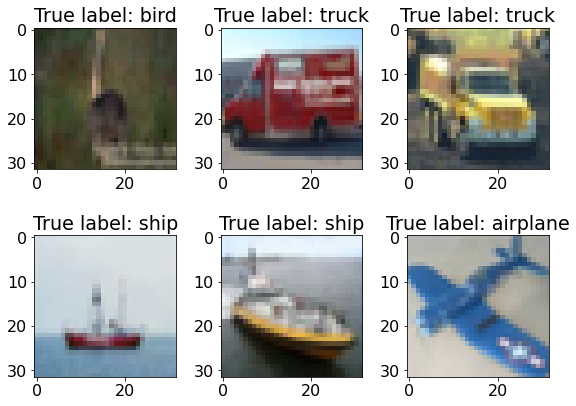

In [8]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(8, 6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow   (np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Compute mean and variance:

In [9]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with augmentations:

In [10]:
oTrainTransform = transforms.Compose([
    transforms.AutoAugment         (policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor            (),
    transforms.Normalize           (vMean, vStd),
])

oTestTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(vMean, vStd),
])


oTrainSet.transform = oTrainTransform
oTestSet .transform = oTestTransform

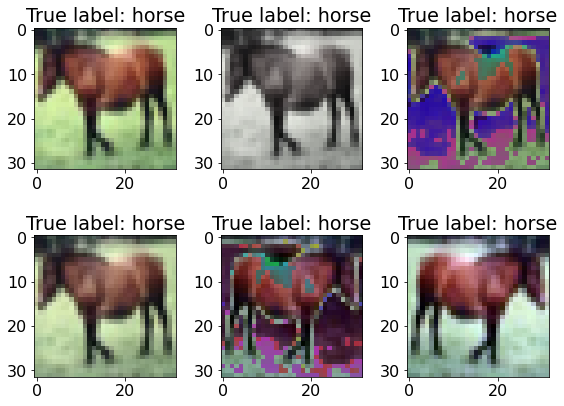

In [11]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(8, 6))
for ax in fig.axes:
    idx   = 7
    mX, y = oTrainSet[idx]
#     mX, y = oTestSet [idx]
    mX    = np.transpose(mX.numpy(), (1,2,0))
    ax.imshow   (np.clip(mX * vStd[None,None,:] + vMean[None,None,:], 0, 1))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Create data loaders:

In [12]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

#### Define the model (ResNet):
<img src='https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/ResBlock.png?raw=true' alt="Drawing" style="width: 150px;"/>

In [13]:
def LeftBranch(C):
    oLeft = nn.Sequential(
        nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding=1, bias=False),
        nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding=1, bias=False)
    )
    return oLeft
               
def RightBranch(C):
    oRight = nn.Identity() #-- Identity

    return oRight

In [14]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super(ResBlock, self).__init__()
        
        self.oLeft  = LeftBranch(C)
        self.oRight = RightBranch(C)

    def forward(self, mX):
        mZ = self.oLeft(mX) + self.oRight(mX)
        return mZ
        
torchsummary.summary(ResBlock(64), (64, 56, 56), device='cpu');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1           [-1, 64, 56, 56]             128
              ReLU-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 64, 56, 56]          36,864
       BatchNorm2d-4           [-1, 64, 56, 56]             128
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
          Identity-7           [-1, 64, 56, 56]               0
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 10.72
Params size (MB): 0.28
Estimated Total Size (MB): 11.77
----------------------------------------------------------------


In [15]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def GetModel():
    d      = 128
    oModel = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),
        nn.Conv2d(d, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),  nn.MaxPool2d(2),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(d, 10)
    )
    
    oModel.apply(weights_init)
    
    return oModel


torchsummary.summary(GetModel(), (3, 32, 32), device='cpu');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1            [-1, 3, 32, 32]               0
            Conv2d-2          [-1, 128, 32, 32]           3,456
       BatchNorm2d-3          [-1, 128, 32, 32]             256
              ReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

### Label Smoothing
* Cross-entropy loss:
$$
\ell_{\mathrm{CE}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \boldsymbol{y}_{i},\log\left(\hat{\boldsymbol{y}}_{i}\right)\right\rangle =-\left\langle \left[\begin{matrix}0\\
1\\
0\\
0
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle 
$$
* Label-smoothing loss:
$$
\ell_{\mathrm{LS}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \left[\begin{matrix}\frac{\epsilon}{3}\\
1-\epsilon\\
\frac{\epsilon}{3}\\
\frac{\epsilon}{3}
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle 
$$
#### Smooth labels code:

In [16]:
N    = 10                         #-- number of samples
C    = 4                          #-- number of classes (labels)
vIdx = torch.randint(0, C, (N,))  #-- correct labels
vIdx

tensor([3, 1, 2, 1, 1, 0, 1, 3, 1, 3])

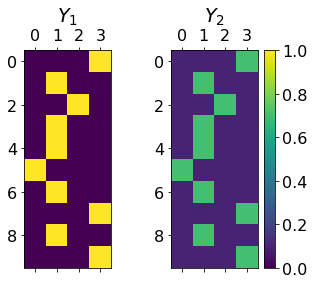

In [17]:
#-- mY1 (one hot):
mY1 = torch.zeros(N, C).scatter_(1, vIdx.unsqueeze(1), 1)

#-- mY2 (smooth):
ϵ   = 0.3
mY2 = torch.empty(N, C).fill_(ϵ / (C-1)).scatter_(1, vIdx.unsqueeze(1), 1-ϵ)

_, ax = plt.subplots(1, 2, figsize=(5, 4))
h = ax[0].matshow(mY1, vmin=0, vmax=1)
h = ax[1].matshow(mY2, vmin=0, vmax=1)
ax[0].set_title('$Y_1$')
ax[1].set_title('$Y_2$')
plt.colorbar(h);

In [18]:
mY1, mY2

(tensor([[0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.]]),
 tensor([[0.1000, 0.1000, 0.1000, 0.7000],
         [0.1000, 0.7000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.7000, 0.1000],
         [0.1000, 0.7000, 0.1000, 0.1000],
         [0.1000, 0.7000, 0.1000, 0.1000],
         [0.7000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.7000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.7000],
         [0.1000, 0.7000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.7000]]))

#### Label smoothing loss:
$$\ell_{\mathrm{LS}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \left[\begin{matrix}\frac{\epsilon}{3}\\
1-\epsilon\\
\frac{\epsilon}{3}\\
\frac{\epsilon}{3}
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle $$
https://github.com/pytorch/pytorch/issues/7455

In [19]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, nClass, ε=0.01):
        super(LabelSmoothingLoss, self).__init__()
        self.nClass = nClass
        self.ε      = ε

    def forward(self, mScore, vY):
        ε      = self.ε
        nClass = self.nClass
        mScore = mScore.log_softmax(dim=-1)

        with torch.no_grad():
            mSmoothY = torch.empty_like(mScore).fill_(ε / (nClass - 1))
            mSmoothY.scatter_(1, vY.unsqueeze(1), 1-ε)

        return torch.mean( torch.sum(-mSmoothY * mScore, dim=-1) )

In [20]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = LabelSmoothingLoss(10, ε=0.1)

In [21]:
nEpochs       = 250
nIter         = nEpochs * len(oTrainDL)

oModel        = GetModel               ().to(DEVICE)
oOptim        = optim.AdamW            (oModel.parameters(), lr=5e-5, betas=(0.9, 0.99), weight_decay=1e-2)
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=5e-3, total_steps=nIter)
lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss: 1.82755 | Val loss: 1.56670 | Train Accuracy: 0.3966 | Val Accuracy: 0.5403 | epoch time: 26.498 | <-- Checkpoint!
Epoch 001: | Train loss: 1.55401 | Val loss: 1.32592 | Train Accuracy: 0.5396 | Val Accuracy: 0.6482 | epoch time: 25.054 | <-- Checkpoint!
Epoch 002: | Train loss: 1.42641 | Val loss: 1.29695 | Train Accuracy: 0.6042 | Val Accuracy: 0.6722 | epoch time: 25.287 | <-- Checkpoint!
Epoch 003: | Train loss: 1.33833 | Val loss: 1.26311 | Train Accuracy: 0.6514 | Val Accuracy: 0.6840 | epoch time: 27.363 | <-- Checkpoint!
Epoch 004: | Train loss: 1.26128 | Val loss: 1.16694 | Train Accuracy: 0.6892 | Val Accuracy: 0.7374 | epoch time: 26.731 | <-- Checkpoint!
Epoch 005: | Train loss: 1.21392 | Val loss: 1.12237 | Train Accuracy: 0.7151 | Val Accuracy: 0.7566 | epoch time: 26.646 | <-- Checkpoint!
Epoch 006: | Train loss: 1.17312 | Val loss: 1.10006 | Train Accuracy: 0.7329 | Val Accuracy: 0.7734 | epoch time: 26.699 | <-- Checkpoint!
Epoch 007: | Train l

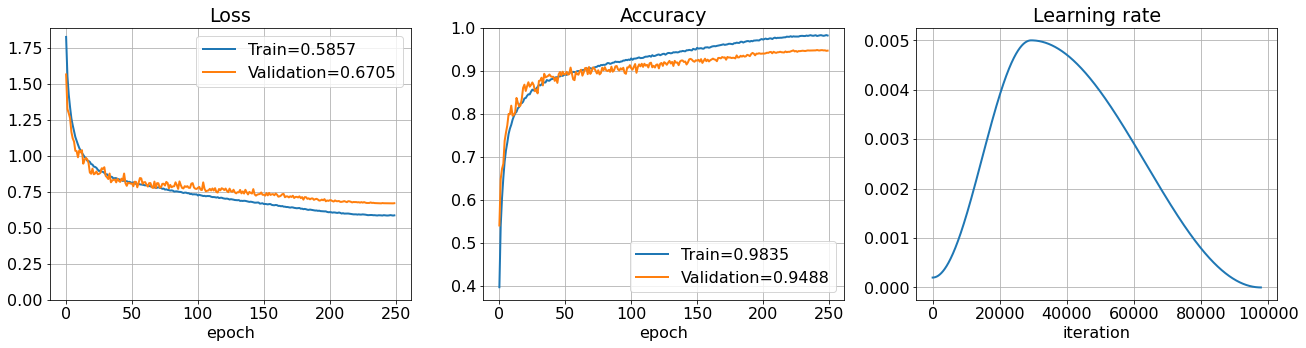

In [22]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainAcc, vValLoss, vValAcc, vLR = lHistory
    
    _, vAx = plt.subplots(1, 3, figsize=(22, 5))
    
    vAx[0].plot      (vTrainLoss, lw=2, label='Train'      f'={vTrainLoss.min():.4f}')
    vAx[0].plot      (vValLoss,   lw=2, label='Validation' f'={vValLoss  .min():.4f}')
    vAx[0].set_title ('Loss')
    vAx[0].set_xlabel('epoch')
    vAx[0].set_ylim  (bottom=0)
    vAx[0].grid      ()
    vAx[0].legend    ()
    
    vAx[1].plot      (vTrainAcc, lw=2, label='Train'      f'={vTrainAcc.max():.4f}')
    vAx[1].plot      (vValAcc,   lw=2, label='Validation' f'={vValAcc  .max():.4f}')
    vAx[1].set_title ('Accuracy')
    vAx[1].set_xlabel('epoch')
    vAx[1].set_ylim  (top=1)
    vAx[1].grid      ()
    vAx[1].legend    ()
    
    vAx[2].plot      (vLR, lw=2)
    vAx[2].set_title ('Learning rate')
    vAx[2].set_xlabel('iteration')
    vAx[2].grid      ()
    
PlotHistory(lHistory)
plt.show   ()